# CNTK 208 Time Series Density Forecasting with Residual LSTM, 
## Part A: Data Loading and Preprocessig

This is the first part of tutorial that shows a full cycle of working with time series. We will also show how to create and use a custom loss function to enable a neural network to perform Density Forecasting or Quantile Regression.
In this part we will download and preprocess and save the data, as the preprocessing may take a considerable amount of time.

## Forecasting time series with neural networks
Neural networks have the ability to learn mapping from inputs to outputs in broad range of situations, and therefore, with proper data preprocessing, can also be used for time series forecasting. However, as a rule, they use a lot of parameters, and a single short time series does not provide enough data for the successful training. This problem can be alleviated by learning across many time series, but if using standard (non-recurrent) neural networks, this may not be a good strategy – the series may diverge a lot for similar past values. However, Recurrent Neural Networks (RNNs) have an internal state, and may learn to respond (forecast) differently series with similar short-term histories, but with dissimilar long-term histories. One of the most attractive RNNs with good long-term memory is Long Short-Term Memory network. An LSTM can be viewed as a powerful and complicated, nonetheless a single layer neural network, see a great introduction at http://colah.github.io/posts/2015-08-Understanding-LSTMs.

We will be working with a dataset from a recent Computational Intelligence in Forecasting International Time Series Competition 2016 [CIF2016]. The
author won this competition with a solution that used R's *stl* funtion to deseasnalize the data. Here we will use a similar Python function from package *seasonal*.   

[CIF2016]: http://irafm.osu.cz/cif

In [1]:
# Import the relevant modules to be used later
import pandas as pd
import numpy as np
import pip
try:
  from seasonal import fit_seasons, adjust_seasons
except:
  pip.main(['install', 'seasonal'])
  from seasonal import fit_seasons, adjust_seasons
import matplotlib.pyplot as plt
import math as m
import random
import os

# Config matplotlib for inline plotting
%matplotlib inline

  Using cached seasonal-0.3.1-py2.py3-none-any.whl


You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


Let's dowload the data:

In [2]:
url = 'http://irafm.osu.cz/cif/cif-dataset.txt'

data_df = pd.read_csv(url,sep=';',header=None)
data_df=data_df.rename(columns={0: 'series', 1:'maxPredHorizon'})

## Data preprocessing
Forecasting time series with Machine Learning algorithms or Neural Networks requires a data preprocessing. This is typically done with a moving (or “rolling”) window along the time axis; at each step, constant size features (inputs) and outputs are extracted, and therefore each series will be a source of many input/output records. For networks with squashing functions like sigmoid, a normalization is often helpful, and it is more needed if we try to train a single network of this kind on many time series differing in size. Finally, for seasonal time series, although in theory a neural network should be able to deal with them well, it often pays off to remove the seasonality before applying a neural network. 

We start with applying logarithm and then we attempt to decompose a time series into seasonal, trend, and irregular components. The logarithm transformation provides two benefits: firstly, it is part of the normalization, secondly, it converts the normally additive seasonal decomposition into the multiplicative one (remember that log(x+y)=log(x)*log(y)), and the multiplicative seasonality is a safer assumption for non-stationary time series. A graph below illustrates this decomposition on one of the series:
<img src="https://az712634.vo.msecnd.net/tutorials/Forecasting-Short-Time-Series-with-LSTM-Neural-Networks/3.png", width=450, height=300>

The competition dataset contains 72 time series with monthly seasonality. Large majority have medium size e.g. 84 points and the requested forecast horizon 12. In this tutorial we will not deal with a small subset of shorter time series with the forecast horizon of 6 - the general approach is the same, but dealing with them would double size of this tutorial.

In [3]:
SEASONALITY=12
OUTPUT_SIZE=12

data_df=data_df[data_df['maxPredHorizon']==OUTPUT_SIZE] #limit to the majority of time series with maxPredHorizon=12
dataNCol=data_df.shape[1]

Mainly due to the relative shortness of the series, we will apply a simple preprocessing that involves moving look-back and forecast windows, normalization and deseasonalization. In this kind of simple preprocessing, the input size is equal to the size of the look back window. Choosing a right input size is not something obvious and best tried experimentally using the validation data set, but I would suggest following rules of thumb:
* if a series is seasonal then the look back window should be equal or larger than seasonality (here 12), 
* in all cases the look back window should be, if possible, similar or larger than the maximum forecasting horizon (even for recurrent nets)
Here I decided to use an input window that is 25% larger than the output window (forecasting horizon):

In [4]:
INPUT_SIZE_MULTIP=1.25  # using some reasoning and backesting, I decided to make input size a bit (here by 25%) larger than the maximum prediction horizon
INPUT_SIZE=int(INPUT_SIZE_MULTIP*OUTPUT_SIZE)

Back to preprocessing algorithm: After subtracting the seasonality, the moving window is applied covering 15 months (points). It is perhaps worth stressing: the input is 15-long vector and the output is 12-long vector, so we are forecasting the whole year ahead at once. This approach works better than trying to forecast just one month ahead – in such a case to get the required 12-step (month) ahead forecast we would need to do it 12 times, and use previous forecast as input 11 times. That leads to instability of the forecast.
<img src="https://az712634.vo.msecnd.net/tutorials/Forecasting-Short-Time-Series-with-LSTM-Neural-Networks/4.png", width=450, height=300>
Then, the last value of trend inside the input window (the big filled dot above) is subtracted from all input and output values for normalization. Input and output windows move forward one step and the procedure is  repeated, until the last point of input window is positioned at lengthOfSeries-outputSize-1, e.g. here 53-12, in case of the training file, or until the last point of the output window equals the last point of the series, in case of the validation file. The validation file contains the training file, but actually only the last record of each series is used – the rest, although later forecasted, is discarded and only used as a “warm-up” region for the recurrent neural network used (LSTM). 
Apart from training and validation files, we also create the test file. It is used for the final forecast, it uses all data points as inputs; as for outputs, when they are unknown, they are just set to zeros - outputs in this file are not used anyway.

The data preprocessing described here is relatively simple, it could have been more sophisticated, by including some other features of time series, like various statistical summaries, differences, and even other algorithm forecasts, which is a kind of ensemble learning. 

BTW, if we were working with longer time series, say 2 years of daily data, we should apply a more elaborate training and validation files creation: e.g. we would step through the data, e.g. in 30 days' steps, and for each step use past data for learning and then produce a forecast, repeating learning many times and saving results for an aggregate anaylsis.

The data preparation below will take a few minutes. During first loop the validation and test files will be created, during the second loop, the training file.
At the end you will see a graph illustrating the last successful decomposition.

v 0 ts1
v 1 ts2
v 2 ts3
v 3 ts4
v 4 ts5
v 5 ts6
v 6 ts7
v 7 ts8
v 8 ts9
v 9 ts10
v 10 ts11
v 11 ts12
v 12 ts13
v 13 ts14
v 14 ts15
v 15 ts16
v 16 ts17
v 17 ts18
v 18 ts19
v 19 ts20
v 20 ts21
v 21 ts22
v 22 ts23
v 23 ts24
v 24 ts25
v 25 ts26
v 26 ts27
v 27 ts28
v 28 ts29
v 29 ts30
v 30 ts31
v 31 ts32
v 32 ts33
v 33 ts34
v 34 ts35
v 35 ts36
v 36 ts37
v 37 ts38
v 38 ts39
v 39 ts40
v 40 ts41
v 41 ts42
v 42 ts43
v 43 ts44
v 44 ts45
v 45 ts46
v 46 ts47
v 47 ts48
v 48 ts51
v 49 ts52
v 50 ts53
v 51 ts59
v 52 ts61
v 53 ts62
v 54 ts63
v 55 ts64
v 56 ts66
tr 0 ts1
tr 1 ts2
tr 2 ts3
tr 3 ts4
tr 4 ts5
tr 5 ts6
tr 6 ts7
tr 7 ts8
tr 8 ts9
tr 9 ts10
tr 10 ts11
tr 11 ts12
tr 12 ts13
tr 13 ts14
tr 14 ts15
tr 15 ts16
tr 16 ts17
tr 17 ts18
tr 18 ts19
tr 19 ts20
tr 20 ts21
tr 21 ts22
tr 22 ts23
tr 23 ts24
tr 24 ts25
tr 25 ts26
tr 26 ts27
tr 27 ts28
tr 28 ts29
tr 29 ts30
tr 30 ts31
tr 31 ts32
tr 32 ts33
tr 33 ts34
tr 34 ts35
tr 35 ts36
tr 36 ts37
tr 37 ts38
tr 38 ts39
tr 39 ts40
tr 40 ts41
tr 41 ts42
tr 42 

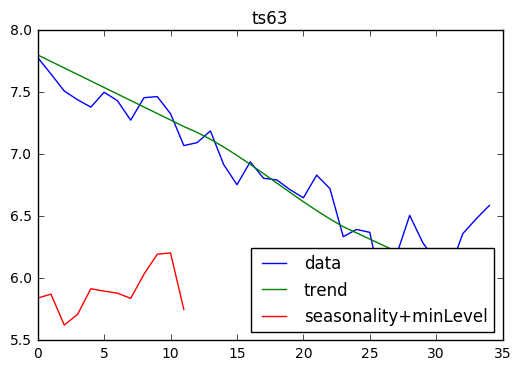

In [5]:
train_df=None; valid_df=None; test_df=None 
#ir=0; validation=True
for validation in [True,False]:
  for ir in range(data_df.shape[0]):
    oneLine_df=data_df.iloc[ir,:]
    series=oneLine_df['series']
    if (validation):
      print('v', ir, series)
    else:
      print('tr', ir, series)
    y=np.float32(oneLine_df.iloc[4:dataNCol])
    y=y[~np.isnan(y)]
    ylog=np.log(y)
    n=y.shape[0]
    if (not validation):
      n=n-OUTPUT_SIZE
      ylog=ylog[range(n)]
    
    seasons, trend = fit_seasons(ylog,period=SEASONALITY)
    if seasons is not None:
      adjusted = adjust_seasons(ylog, seasons=seasons)
      plt.clf()
      plt.plot(ylog, label='data')
      plt.plot(trend, label='trend')
      plt.plot(seasons+np.min(trend), label='seasonality+minLevel')
      plt.legend(loc='lower right')
      plt.title(series)
      plt.pause(0.0001)
      seasonality_vect=(ylog-adjusted)
    else:
      trend=ylog
      adjusted=ylog
      seasonality_vect=np.zeros(n)
    
    save_df=None #inn=INPUT_SIZE-1
    for inn in range(INPUT_SIZE-1,(n-OUTPUT_SIZE)):
      level=trend[inn] #last "trend" point in the input window is the "level" (the value used for the normalization)
      sav_df=pd.DataFrame(data=[series], columns=['series'])
      for ii in range(1,INPUT_SIZE+1):
        sav_df['i'+str(ii)]=adjusted[inn-INPUT_SIZE+ii]-level  #inputs: past values normalized by the level
      for ii in range(1,OUTPUT_SIZE+1):
        sav_df['o'+str(ii)]=adjusted[inn+ii]-level #outputs: future values normalized by the level.
      #what follows will not be used for training or prediction, it will be used for error calculation
      sav_df['level']=level
      for ii in range(1,OUTPUT_SIZE+1):
        sav_df['s'+str(ii)]=seasonality_vect[inn+ii]
      for ii in range(1,INPUT_SIZE+OUTPUT_SIZE+1):
        sav_df['t'+str(ii)]=y[inn+ii-INPUT_SIZE]   #actuals
      if save_df is None:
        save_df=sav_df
      else:
        save_df=save_df.append(sav_df)
    #print(save_df.to_string())
    if validation:
      if valid_df is None:
        valid_df=save_df
        test_df=save_df
      else:
        valid_df=valid_df.append(save_df)
        test_df=test_df.append(save_df)
    else:
      if train_df is None:
        train_df=save_df
      else:
        train_df=train_df.append(save_df)
        
    if validation:    #rest of test
      save_df=None
      for inn in range((n-OUTPUT_SIZE),n):
        level=trend[inn] #last "trend" point in the input window is the "level" (the value used for the normalization)
        sav_df=pd.DataFrame(data=[series], columns=['series'])
        for ii in range(1,INPUT_SIZE+1):
          sav_df['i'+str(ii)]=adjusted[inn-INPUT_SIZE+ii]-level  #inputs: past values normalized by the level
        for ii in range(1,OUTPUT_SIZE+1):
          sav_df['o'+str(ii)]=0 #unknown value
        #what follows will not be used for training or prediction, it will be used for error calculation
        sav_df['level']=level
        for ii in range(1,OUTPUT_SIZE+1):
          indx=inn+ii
          while indx>=n:
            indx=indx-SEASONALITY  
          sav_df['s'+str(ii)]=seasonality_vect[indx]
        for ii in range(1,INPUT_SIZE+OUTPUT_SIZE+1):
          sav_df['t'+str(ii)]=0   #unknown actuals
        if save_df is None:
          save_df=sav_df
        else:
          save_df=save_df.append(sav_df)
      test_df=test_df.append(save_df)      # print(train_df.shape, valid_df.shape, test_df.shape)


Now, let's save the three files into a data directory.

In [8]:
data_dir = './data/CIF_data'
if not os.path.exists(data_dir):
  print("making "+data_dir)
  os.mkdir(data_dir)   

train_filename = data_dir + '/train.csv'
validation_filename = data_dir + '/validation.csv'
test_filename = data_dir + '/test.csv'
    
train_df.to_csv(path_or_buf=train_filename, index=False) 
valid_df.to_csv(path_or_buf=validation_filename, index=False) 
test_df.to_csv(path_or_buf=test_filename, index=False) 

making ./data/CIF_data
